# 필요한 모듈 불러오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

#32x32크기의 컬러이미지가 50000장 있음

(50000, 32, 32, 3)

## 불러온 데이터 시각화

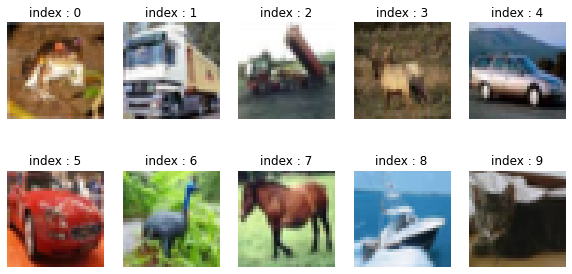

In [3]:
plt.figure(figsize=(10,5))   #이미지 전체 프레임 크기 결정

for i in range(10):  # 0~9
    plt.subplot(2, 5, i+1)  # 여러 개의 이미지를 한 번에 띄우고 싶을 때 plt.subplot(row, col, index)
    plt.imshow(train_x[i])
    plt.title(f'index : {i}')
    plt.axis('off')   #불필요한 축을 지움

plt.show()

### 픽셀의 범위 [0,255]

In [4]:
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


### 중간값을 맞춰주기 위해 이미지를 [-1, 1]로 정규화

In [5]:
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


# 데이터 섞기

- tensorflow의 Dataset 이용

In [6]:
BUFFER_SIZE = 50000  # 전체 데이터를 섞기 위해 버퍼사이즈를 데이터의 총 개수로 맞춰줌
BATCH_SIZE = 256   # 모델이 한 번에 학습할 데이터의 양

- from_tensor_slices() : 리스트, 넘파이, 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있음

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 모델 설계

## GAN
- **생성자(Generator)** : 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성. 무에서 유를 생성
- **판별자(Discriminator)** : 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지 Fake인지에 대한 판단 정도를 실수값으로 출력

## DCGAN
- Deep Convolutional GAN
- GAN을 더욱 발전시켜 훨씬 그럴듯한 고화질 이미지 생성을 이루어냄

## 생성자 구현

### BatchNormalization
- cs231n lecture 06
- 이전 레이어로부터의 activation의 평균을 0, 분산을 1로 만듦.
- 신경망의 가중치가 폭발하지 않도록 **가중치 값을 정규화** 
- 이러한 효과는 **학습과정을 안정적**으로 가져갈 수 있도록 함
- generator의 ouput과 discriminator의 input을 제외하고, discriminator와 generator model 모두에 사용하도록 권장
- **Batchnrom을 모든 layer에 적용하는 것은 sample에 변동을 주며 모델을 불안정**하게 함
- 그렇기 때문에 **discriminator의 input과 generator output에 batch norm을 적용하는 것은  피해야 함**

참고 링크 : https://flonelin.wordpress.com/2020/05/20/%EC%95%88%EC%A0%95%EC%A0%81%EC%9D%B8-generative-adversarial-network-%ED%8A%B8%EB%A0%88%EC%9D%B4%EB%8B%9D%EC%9D%84-%EC%9C%84%ED%95%9C-%ED%8C%81%EB%93%A4/

### Conv2DTranspose
- 일반적인 Conv2D와는 반대로 이미지 사이즈를 넓혀주는 층
- 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) -> (16, 16, 64) -> (32, 32, 3)
- (32, 32, 3)은 기존에 준비한 데이터셋의 shape와 같음

### tanh
- [-1,1]이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [8]:
def make_generator_model():
    
    #Start
    model = tf.keras.Sequential()
    
    #First : Dense Layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Second : Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    #Third : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Fourth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Fifth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [9]:
generator = make_generator_model()

generator.summary()

# 8x8x256 = 16384

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 랜덤 노이즈를 입력으로 하여 생성자로 랜덤 이미지 생성
- 모델이 학습되지 않았기 때문에 결과물도 큰 의미가 있지 않을 것

In [10]:
#tf.random.normal : 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터
noise = tf.random.normal([1, 100])

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 

만들어진 **생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성**

단, 지금은 학습하는 것이 아니므로 **training=False**를 설정해 주어야 함 

Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 

training=False을 주어야 올바른 결과를 얻을 수 있음

In [11]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

맨 처음 1 : 1개(batch_size = 1)

32, 32, 3 : 이미지의 사이즈 -> **규격에 잘 맞게 출력되었다.**

- 위에서 생성한 이미지 시각화

matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 

0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 함

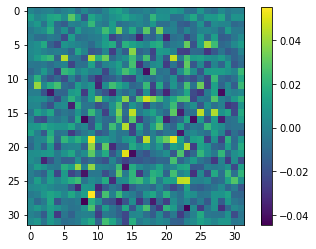

In [12]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

모델 학습이 진행되지 않았기 때문에 의미없는 이미지가 출력되었지만, shape가 생성자의 출력 규격에 맞기 때문에 넘어간다.

## 판별자 구현

- 입력 : (32, 32, 3)
- 출력 : 하나의 숫자(진짜라고 판단하는 정도)

In [13]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

# 생성자 모델에서 BatchNormalization을 썼듯이, 판별자에서는 Dropout 사용

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 **Conv2D 층**으로 이미지의 크기를 점점 줄여나감

첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 

(32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됨.

마지막에는 **Flatten 층**을 사용해 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 1차원 벡터로 변환

그 후 마지막 **Dense Layer**를 거쳐 **단 하나의 값을 출력**

- 위에서 랜덤하게 생성한 이미지 generated_image를 판별

In [15]:
decision = discriminator(generated_image, training=False)
decision

#텐서플로우의 텐서형태로 출력됨

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00041721]], dtype=float32)>

## 손실함수
- GAN은 손실함수로 **교차 엔트로피(cross entropy)**를 사용
- 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지 정량적으로 계산할 때 많이 쓰임
- 판별자는 한 개의 이미지가 **가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제**를 풀어야 하므로 **이진 교차 엔트로피 사용**

Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 

각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과

- 생성자 : 판별자가 Fake Image에 대해 판별한 값 D(Fake Image) 값이 1에 가까워지는 것
- 판별자 : Real Image 판별값 D(Real Image)는 1에, Fake Image 판별값 D(Fake Image)는 0에 가까워지는 것

생성자든 판별자든 손실함수에 들어가는 값은 모두 **판별자의 판별값**

**하지만 BinaryCrossEntropy에 입력해야 할 값은 0~1 사이에 분포하는 확률값**

따라서 **from_logits = True**로 설정해주어야 

BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

사실 이 부분은 계속 의문이다. 굳이 이렇게 따로 코드를 작성하지 않고 판별자 함수를 생성할 때,

맨 마지막 Dense Layer에서 activation function을 sigmoid로 지정해주면 되는 것 아닌가 싶다.

우선 프로젝트를 끝까지 진행해보고 시간이 된다면 지금 생각한 대로 함수를 바꾸어서 진행해보고자 한다.

**cross_entropy를 활용해 계산할 loss**
- fake_output : 생성자가 생성한 **가짜 이미지**를 판별자에 입력시켜서 판별한 값
- real_output : 기존에 있던 **진짜 이미지**를 판별자에 입력시켜서 판별한 값

**fake_output과 real_output을 각각 1 또는 0에 비교**
- tf.ones_like(), tf.zeros_like() 함수
- 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용

### generator_loss
- 가짜 이미지가 1에 가까운 판별값이 나오길 원함
- tf.ones_like와의 교차 엔트로피 값 계산

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
- 진짜 이미지 값은 1에 가깝게, 가짜 이미지 값은 0에 가깝게 -> 두 가지 loss 모두 계산
- real_output - 1로 채워진 벡터와 비교
- fake_output - 0으로 채워진 벡터와 비교

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy
- 판별자의 정확도
- 마냥 높다고 좋은 게 아님 : 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻
- **real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적**

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
                                           # 1) real_output의 각 원소가 0.5 이상인지 True, False로 판별
                                  # 2) 1)의 결과가 True면 1, False면 0으로 변환
                    # 3) 2)의 결과를 평균내어 해당 배치의 정확도를 계산
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 최적화 함수 
- Adam 사용
- learning_rate 변경
- 생성자와 판별자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 함

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- 샘플은 한 번에 16장 생성
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로 고정된 seed 노이즈 생성
- 100차원의 노이즈를 총 16개 (16,100) 형상의 벡터 생성

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 설계
- 하나의 미니 배치 당 진행할 **train_step 함수**를 먼저 만들어야 함
- 학습시킬 훈련 함수 위에 **@tf.function** 이라는 데코레이터를 붙여서 사용
- @tf.function 데코레이터가 사용된 함수에 입력된 입력은 **Tensorflow의 graph 노드가 될 수 있는 타입**으로 자동 변환

## train_step 함수

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- (1) 입력 데이터: **Real Image 역할**을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 **FAKE IMAGE를 생성하기 위한 noise**를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 **가중치 갱신을 위한 Gradient를 자동 미분으로 계산**하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 **noise를 입력받은 후 generated_images 생성**
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 **real_output, fake_output 출력**
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator **각각의 loss 계산**
- (7) accuracy 계산 : fake_output, real_output으로 **discriminator의 정확도 계산**
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 **gradient를 자동으로 계산**
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 **가중치 갱신**
- (10) 리턴값 : 이번 스텝에 계산된 **loss와 accuracy를 리턴**

### 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### Loss, Accuracy 그래프

GAN 학습 과정은 지도학습 모델보다 까다로움. 두 모델이 서로의 학습 과정에 영향을 주고받기 때문.

train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 

**history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수**

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

###  정기적으로 모델을 저장하기 위한 checkpoint
- **tf.train.Checkpoint**
- 파일명 : **training_checkpoints**
- 모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적
- checkpoint에는 optimizer, 생성자, 판별자가 학습한 모델 가중치를 저장


In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints/try3'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 모델 학습

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

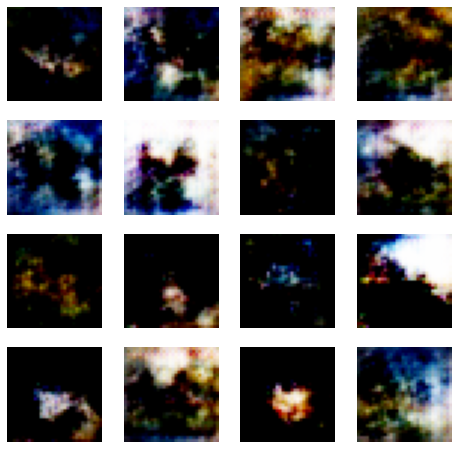

Time for training : 787 sec


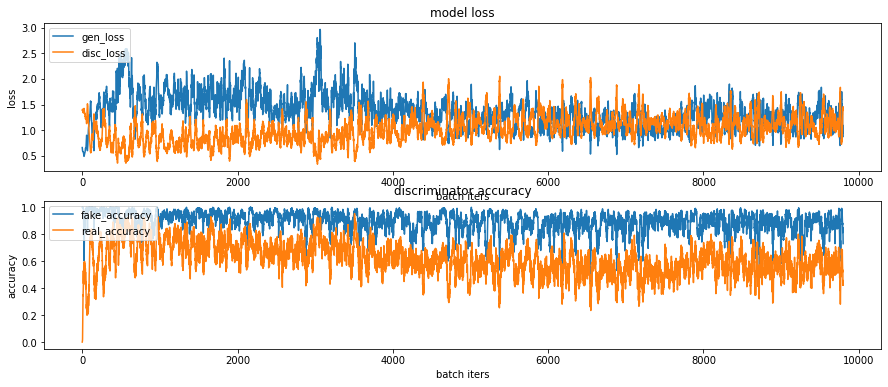

CPU times: user 13min 31s, sys: 1min 22s, total: 14min 54s
Wall time: 13min 8s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

loss는 수렴하지만 accuracy는 아직 1에 가깝기 때문에 학습이 잘 되었다고 할 수는 없을 것 같다.

생성된 이미지가 형체를 알아보도 어려운 이미지이며, 그나마 이름을 붙여보자면 곰팡이가 슬어버린 식빵 이미지라고 할 수 있을 것 같다.

원한 이미지는 위와 같은 이미지가 아니므로 모델의 층을 개선하고, 하이퍼 파라미터 조정을 통해 이미지 생성을 다시 시도하고자 한다.

###  checkpoint 모듈을 활용하여 모델 로드
- 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 있음
- 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비이기 때문에 checkpoint를 이용해 저장해놓은 모델을 불러옴

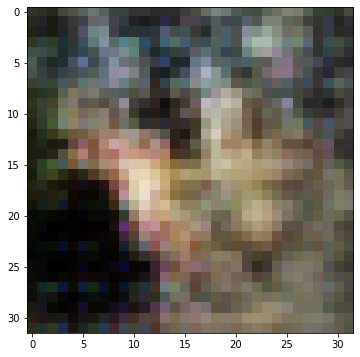

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints/try3'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

## 학습과정 시각화
- 생성했던 샘플 이미지들을 합쳐 GIF 파일 만들기

In [30]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/cifar_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/fashion/cifar_dcgan.gif': No such file or directory


## 생성자 수정

In [31]:
def make_generator_model():
    
    #Start
    model = tf.keras.Sequential()
    
    #First : Dense Layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    #Second : Reshape Layer
    model.add(layers.Reshape((4, 4, 256)))
    
    #Third : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    #Fourth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    #Fifth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    #Sixth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [32]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 128)       262144    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

## 판별자 수정

In [33]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1,  activation='sigmoid'))
    
    return model

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5)

In [35]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 256)        

### check point

In [36]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints/try4'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 모델 학습

In [37]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 모델 훈련

In [43]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 30 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [44]:
save_every = 5
EPOCHS = 200

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

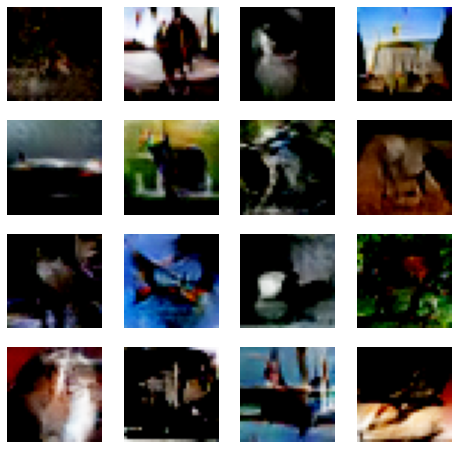

Time for training : 5245 sec


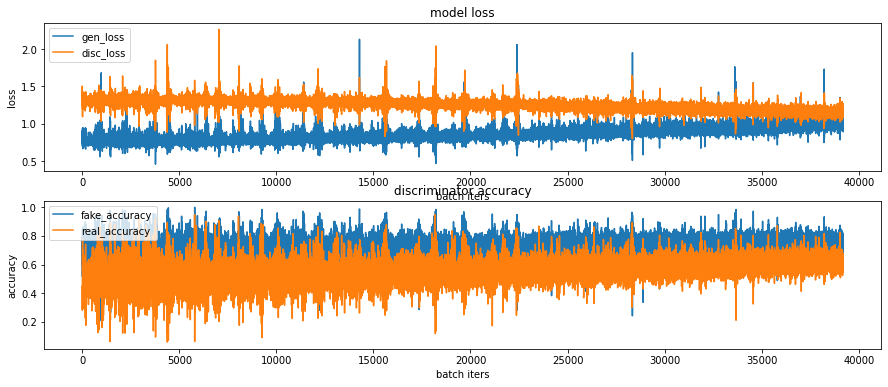

CPU times: user 1h 30min 33s, sys: 7min 17s, total: 1h 37min 50s
Wall time: 1h 27min 28s


In [45]:
%%time
train(train_dataset, EPOCHS, save_every)

# GIF 만들기

### check point 불러오기

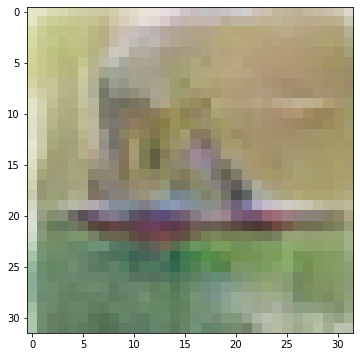

In [80]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints/try4'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

In [81]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan_up.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/ciar10/cifar_dcgan_up.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/ciar10/cifar_dcgan_up.gif': No such file or directory


# 회고

생성자와 판별자를 수정하고 만든 이미지는

그렇게 만족스러운 결과는 아니지만.. 곰팡이에 비해서는 그래도 아주 조금은 동물 형상이라고 할 수 있을 것 같은 것이 만들어졌다.

check point에서 불러온 이미지는 배(boat)처럼 보이는 이미지가 생성되었다.

사실 이번 프로젝트는 코드나 이론을 제대로 이해하지 못한 채로 진행했다.

미흡한 점이 매우 많고,

판별자와 생성자를 수정할 땐, 레이어를 하나씩 추가해본다던지, Batch Normalization, Dropout을 없애본다던지

거의 A/B 테스트처럼 진행을 했는데, 학습 시간이 오래 걸려 지치기도 했다.

GAN을 이해를 잘 못해서 그런가 큰 흥미를 느끼지도 못했고 어렵기만 했다...

이러한 점이 모델의 성능까지 영향을 끼쳤던 것인걸까 싶다...

차라리 시계열 데이터 과제가 더 나을 정도로 이번 과제는 심하게 막막했다.

갈 길이 멀다.